This notebook is my own correction of the [exercise 1, lesson 4](https://www.udacity.com/course/viewer#!/c-ud359/l-729939275/e-712470088/m-712470089), from the Udacity Introduction to Data Science course. The purpose is to play around with ``ggplot`` and the subway dataset. The dataset is rich enough to expose real problems with data plotting (compared to the quizzes from the lessons). I will plot the averge riderships by day. Note that the number of riderships is not a good proxy, since the number of week days is not the same (you can have more Mondays than Sundays for a give month).

First of all, let's import the usual tools:

In [1]:
%matplotlib inline
import pandas as pd
from ggplot import *
from datetime import *

And now we can load the data from the course:

In [2]:
turnstile_weather = pd.read_csv('data/turnstile_data_master_with_weather.csv')
turnstile_weather.is_copy = False

Before plotting, data should usually be manipulated. ``ggplot`` can do it in simple cases, typically counting occurences with ``geom_histogram``. Summing and averaging should be done before plotting in the data set itself or in another data set. This kind of operation can be done in ``pandas`` directly. Since the course is based on ``pandasql``, I will use it here either. I guess that more advance plotting tools could prevent that manipulate data directly.

In [3]:
import pandasql

When using ``pandasql``, you have to be careful about the columns name. They should follow the [SQLite column naming conventions](http://www.sqlite.org/lang_keywords.html), otherwise an exeception error message will be thrown away. That's why the columns should be renamed, as described [here](http://bryansmithphd.com/) (this blog has only one post, but it happened to be very useful to me). The columns are also renamed in the code snippets from the quizzes, but I didn't notice it at that time.

In [4]:
turnstile_weather.rename(columns = lambda x: x.replace(' ', '_').lower(), inplace=True) 

Check the result by displaying the columns name:

In [5]:
print turnstile_weather.columns

Index([u'unnamed:_0', u'unit', u'daten', u'timen', u'hour', u'descn',
       u'entriesn_hourly', u'exitsn_hourly', u'maxpressurei', u'maxdewpti',
       u'mindewpti', u'minpressurei', u'meandewpti', u'meanpressurei', u'fog',
       u'rain', u'meanwindspdi', u'mintempi', u'meantempi', u'maxtempi',
       u'precipi', u'thunder'],
      dtype='object')


In [6]:
turnstile_weather['week_day'] = turnstile_weather['daten'].map(
            lambda x: datetime.strptime(x, '%Y-%m-%d').weekday())

The ``weekday`` function maps a date with a week day (as an integer from 0 to 6). We can now cumulate by day the number of entries.

In [7]:
q = """
select daten, week_day, sum(entriesn_hourly)
from turnstile_weather
group by daten
"""
entries_day = pandasql.sqldf(q.lower(), locals())

For concenience, the summed column will be renamed.

In [8]:
entries_day.rename(columns={'sum(entriesn_hourly)': 'entriesn_daily'}, inplace=True)

In [9]:
print entries_day

         daten  week_day  entriesn_daily
0   2011-05-01         6         2370432
1   2011-05-02         0         5317143
2   2011-05-03         1         5840327
3   2011-05-04         2         5836427
4   2011-05-05         3         5900352
5   2011-05-06         4         5862195
6   2011-05-07         5         3530107
7   2011-05-08         6         2683954
8   2011-05-09         0         5346657
9   2011-05-10         1         5767646
10  2011-05-11         2         5894916
11  2011-05-12         3         5907349
12  2011-05-13         4         5863115
13  2011-05-14         5         3537323
14  2011-05-15         6         2685406
15  2011-05-16         0         5428740
16  2011-05-17         1         5669840
17  2011-05-18         2         5866031
18  2011-05-19         3         5811475
19  2011-05-20         4         5792009
20  2011-05-21         5         3627123
21  2011-05-22         6         2717714
22  2011-05-23         0         5376031
23  2011-05-24  

The data set is now clean. The average will also be calculated using ``pandasql``.

In [10]:
q = """
select week_day, avg(entriesn_daily)
from entries_day
group by week_day
"""
entries_week_day = pandasql.sqldf(q.lower(), locals())

In [11]:
print entries_week_day

   week_day  avg(entriesn_daily)
0         0           4826019.20
1         1           5749488.50
2         2           5890659.00
3         3           5871662.25
4         4           5782693.25
5         5           3511026.25
6         6           2636022.80


Everything looks really good, we can now plot the result.

/Users/arnaud/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


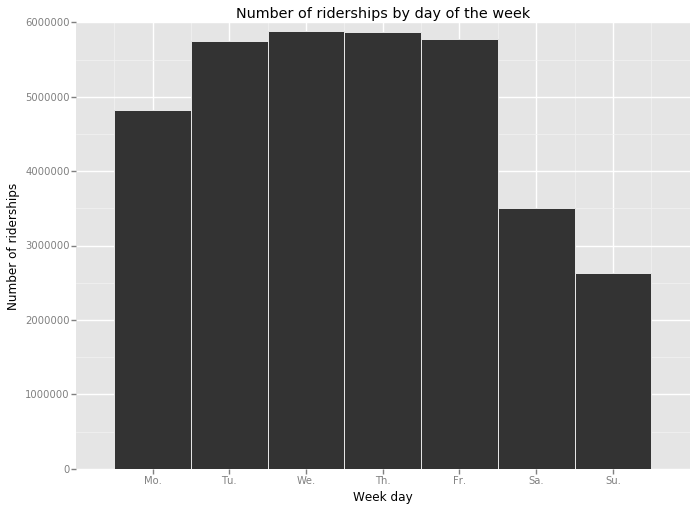

<ggplot: (280598329)>

In [12]:
ggplot(entries_week_day, aes('week_day', 'avg(entriesn_daily)')) + geom_bar(stat="bar") + \
    scale_x_continuous(breaks=[0,1,2,3,4,5,6], labels=["Mo.", "Tu.", "We.", "Th.", "Fr.", "Sa.", "Su."]) + \
    scale_y_continuous(labels='thousands') + \
    xlab('Week day') + ylab('Number of riderships') + \
    ggtitle('Number of riderships by day of the week')

Not really a suprise, there are far more riderships during the business days than during the weekend. The busiest day is Wednesday, but it is very close to Tuesday, Thursday and Friday.